In [138]:
import os
import json
import yaml
import time
from redis import Redis
from rq import Queue, Retry
from rq.job import Job
import traceback
import sys
import networkx as nx
import warnings
import matplotlib.cbook
from joyflo import reactflow_to_networkx

In [139]:
from FUNCTIONS.GENERATORS import *
from FUNCTIONS.TRANSFORMERS import *
from FUNCTIONS.VISORS import *

In [140]:
stream = open('STATUS_CODES.yml', 'r',encoding="utf8")
STATUS_CODES = yaml.safe_load(stream)

from utils import PlotlyJSONEncoder

import os

REDIS_HOST = os.environ.get('REDIS_HOST', 'localhost')
REDIS_PORT = os.environ.get('REDIS_PORT', 6379)

#### *Configuring Redis*

In [141]:
r = Redis(host=REDIS_HOST, port=REDIS_PORT)
q = Queue('flojoy', connection=r)

In [142]:
# Load React flow chart object from JSON file

f = open('./test-fc.json')
fc = json.loads(f.read())
elems = fc['elements']

#### *Configuring NETWORKX*

In [143]:
DG = nx.DiGraph()
DG.clear()

#### *Converting the elements to nodes*

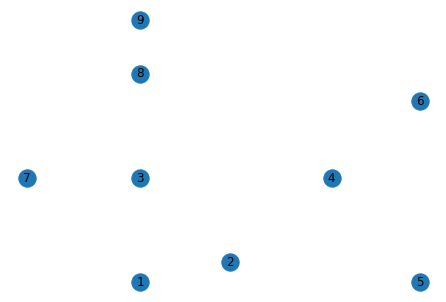

In [144]:
for i in range(len(elems)):
    el = elems[i]
    if 'source' not in el:
        data = el['data']
        ctrls = data['ctrls'] if 'ctrls' in data else {}
        DG.add_node(i+1, pos=(el['position']['x'], el['position']['y']), id=el['id'], ctrls=ctrls)
        elems[i]['index'] = i+1
        elems[i]['label'] = el['id'].split('-')[0]

pos = nx.get_node_attributes(DG,'pos')
nx.draw(DG, pos, with_labels=True)

#### *Adding Edges*

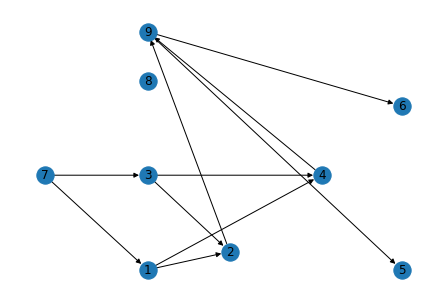

In [145]:
edge_label_dict = {}
def get_tuple(edge):
    e = [-1, -1]
    src_id = edge['source']
    tgt_id = edge['target']

    type = edge['type']
    if type == 'special':
        label = edge['label']
    else:
        label = 'default'
    if tgt_id not in edge_label_dict.keys():
        edge_label_dict[tgt_id] = []
    edge_label_dict[tgt_id].append({
        'source': src_id,
        'label':label
    })

    # iterate through all nodes looking for matching edge
    for el in elems:
        if 'id' in el:
            if el['id'] == src_id:
                e[0] = el['index']
            elif el['id'] == tgt_id:
                e[1] = el['index']
    return tuple(e)

for i in range(len(elems)):
    el = elems[i]
    if 'source' in el:
        # element is an edge
        e = get_tuple(el)
        DG.add_edge(*e)
nx.draw(DG, pos, with_labels=True)
# print(edge_label_dict)

#### *Adding Labels to each nodes*

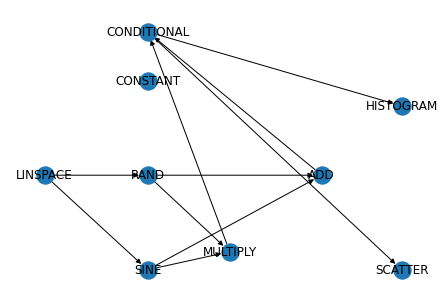

In [146]:
labels = {}
type = {}

for el in elems:
    # if element is not a node
    if 'source' not in el:
        labels[el['index']] = el['data']['label']
        type[el['index']] = el['type']
                
nx.set_node_attributes(DG, labels, 'cmd')
nx.set_node_attributes(DG, type,'type')
nx.draw(DG, pos, with_labels=True, labels = labels)

#### *UTIL FUNCTIONS*

In [147]:
def get_node_data_by_id():
    nodes_by_id = dict()
    for n, nd in DG.nodes().items():
        nodes_by_id[n] = nd
    return nodes_by_id

def report_failure(job, connection, type, value, traceback):
    print(job, connection, type, value, traceback)

def jid(n):
    return 'JOB_ID_{0}'.format(n)

topological_sorting = nx.topological_sort(DG)
nodes_by_id = get_node_data_by_id()

#### TESTING THE CONSTRUCTED GRAPH

In [148]:
for n, nd in DG.nodes().items():
    print('node', n, 'node data', nd)

for node in nx.topological_sort(DG):
    print(node)

node 1 node data {'pos': (291, 105), 'id': 'SINE-userGeneratedNode_1646417316016', 'ctrls': {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}}, 'cmd': 'SINE', 'type': 'default'}
node 2 node data {'pos': (523, 135), 'id': 'MULTIPLY-userGeneratedNode_1646417352715', 'ctrls': {}, 'cmd': 'MULTIPLY', 'type': 'default'}
node 3 node data {'pos': (291, 262), 'id': 'RAND-userGeneratedNode_1646417371398', 'ctrls': {}, 'cmd': 'RAND', 'type': 'default'}
node 4 node data {'pos': (783, 262), 'id': 'ADD-userGeneratedNode_1646417428589', 'ctrls': {}, 'cmd': 'ADD', 'type': 'default'}
node 5 node data {'pos': (1009, 105), 'id': 'SCATTER-userGeneratedNode_1646417560399', 'ctrls': {}, 'cmd': 'SCATTER', 'type': 'default'}
node 6 node data {'pos': (1009, 377), 'id': 'HISTOGRAM-userGeneratedNode_1646417604301'

In [149]:
nodes_edge_type_dict = {}
for node in nx.topological_sort(DG):
    target_id = nodes_by_id[node]['id']

    for pred in DG.predecessors(node):
        source_id = nodes_by_id[pred]['id']
        edge_id = 'reactflow__edge-'+source_id+'null-'+target_id+'null'
        edge_type = elems[elems['id'] == edge_id]['type']
        print(edge_type) 
    

TypeError: list indices must be integers or slices, not str

In [ ]:
def check_predecessor(n):
    successful_jobs_count = 0
    predecessor_count = 0
    predecessor_payloads = []
    for p in DG.predecessors(n):
        predecessor_count = predecessor_count + 1
        job_id = jid(p)
        # print("predecessor, ",job_id)
        try:
            job = Job.fetch(job_id, connection=r)
            nd = nodes_by_id[p]
        except Exception:
            print(traceback.format_exc())

        attempt_count,is_any_node_failed = 0,False
        while True:
            time.sleep(0.5)
            job_status= job.get_status(refresh=True)
            redis_payload = job.result
            attempt_count += 1
            print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
            # if attempt_count > 9:
            #     job.delete()
            #     break
            if job_status == 'finished':
                successful_jobs_count = successful_jobs_count + 1
                predecessor_payloads.append(redis_payload)
                break
            if is_any_node_failed:
                print('canceling', nd['cmd'], 'due to failure in another node')
                job.delete()
                job_status = "cancelled"
                break
            if job_status == 'failed':
                is_any_node_failed = True
                break
            if job_status == 'deferred':
                registry = q.deferred_job_registry
                registry.requeue(job_id)
    return successful_jobs_count == predecessor_count,predecessor_payloads

In [ ]:
'''
    TODO all types of registries, deferred, failed, finished.
'''

def handle_special_type_node(node_serial,node_label,total_enqued_node,q,job_id):

    if node_label == "CONDITIONAL":
        operator = nodes_by_id[node_serial]['ctrls']['CONDITIONAL_OPERATOR']['operator']
        # print(operator)
        status,payloads = check_predecessor(node_serial)
        
        if status:
            if len(payloads) == 2:
                payload_1 = payloads[0]
                payload_2 = payloads[1]

                print("payload 1 ",payload_1)
                print("payload 2 ",payload_2)

                if operator == 'IS_GREATER_THAN':
                    return 'true'
        

In [ ]:
total_enqued_node = 0
enqued_jobs_list = []
labeled_edge = "true"

for n in nx.topological_sort(DG):
    cmd,ctrls,type = get_node_data_by_id()[n]['cmd'],get_node_data_by_id()[n]['ctrls'],get_node_data_by_id()[n]['type']

    # print('node:', n, 'ctrls:', ctrls, "cmd: ", cmd, "type: ",type)
    job_id = jid(n)
    if(type == 'special'):
        labeled_edge = handle_special_type_node(node_serial = n,node_label = cmd,total_enqued_node = total_enqued_node,q= q,job_id = job_id)
    else:
        func = getattr(globals()[cmd], cmd)
        print('func:', func)

        s = ' '.join([STATUS_CODES['JOB_IN_RQ'], cmd.upper()])
        r.set('SYSTEM_STATUS', s)

        '''
            TODO: MUST CHECK PREDECESSORS IF ANYONE OF THEM IS SPECIAL TYPE NODES OR NOT
        '''

        if len(list(DG.predecessors(n))) == 0:
            # print('{0} ({1}) has no predecessors'.format(cmd, n))
            q.enqueue(func,
                retry=Retry(max=100), # TODO: have to understand why the SINE node is failing for few times then succeeds
                job_timeout='3m',
                on_failure=report_failure,
                job_id = job_id,
                kwargs={'ctrls': ctrls},
                result_ttl=500)
            print('ENQUEUING...', cmd, job_id, ctrls)
        else:
            previous_job_ids = []
            for p in DG.predecessors(n):
                prev_cmd = DG.nodes[p]['cmd']
                prev_job_id = jid(p)
                previous_job_ids.append(prev_job_id)
                # print(prev_cmd, 'is a predecessor to', cmd)
            q.enqueue(func,
                retry=Retry(max=100),
                job_timeout='3m',
                on_failure=report_failure,
                job_id=job_id,
                kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids,},
                depends_on=previous_job_ids,
                result_ttl=500)
            print('ENQUEUING...', cmd, job_id, ctrls, previous_job_ids)

        total_enqued_node = total_enqued_node + 1
        enqued_jobs_list.append(job_id)

func: <function LINSPACE at 0x00000231455DF130>
ENQUEUING... LINSPACE JOB_ID_7 {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}
func: <function CONSTANT at 0x00000231455DF010>
ENQUEUING... CONSTANT JOB_ID_8 {'CONSTANT_2.0_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}, 'CONSTANT_8_CONSTANT': {'functionName': 'CONSTANT', 'param': 'constant', 'value': 8}}
func: <function SINE at 0x000002313C4DE5F0>
ENQUEUING... SINE JOB_ID_1 {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}} ['JOB_ID_7']
func: <function RAND at 0x00000231455DEF80>
ENQUEUING... RAND JOB_ID_3 {}

TypeError: '>' not supported between instances of 'dict' and 'dict'

In [ ]:
try:
    job.fetch('JOB_ID_9', connection=r)
    print('Status: %s' % job.get_status())
except Exception:
    print("no such jobs")

no such jobs





Getting Node Outputs
Job status: LINSPACE finished origin: flojoy attempt: 1
Job status: CONSTANT finished origin: flojoy attempt: 1
Job status: SINE finished origin: flojoy attempt: 1
Job status: RAND finished origin: flojoy attempt: 1
Job status: ADD finished origin: flojoy attempt: 1
Job status: MULTIPLY finished origin: flojoy attempt: 1
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13544\1689592644.py", line 14, in <module>
    job = Job.fetch(job_id, connection=r)
  File "c:\Users\User\miniconda3\envs\dev\lib\site-packages\rq\job.py", line 350, in fetch
    job.refresh()
  File "c:\Users\User\miniconda3\envs\dev\lib\site-packages\rq\job.py", line 591, in refresh
    raise NoSuchJobError('No such job: {0}'.format(self.key))
rq.exceptions.NoSuchJobError: No such job: b'rq:job:JOB_ID_9'

Job status: CONDITIONAL finished origin: flojoy attempt: 1
Job status: HISTOGRAM started origin: flojoy attempt: 1
Job status: HISTOGRAM queued origin: flo

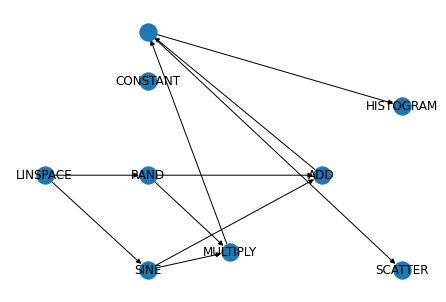

In [ ]:
all_node_results = []
topological_sorting = reactflow_to_networkx(elems)['topological_sort']

print('\n\n')
print("Getting Node Outputs")

is_any_node_failed = False
for n in topological_sorting:
    job_id = jid(n)
    nd = nodes_by_id[n]
    # TODO have to investigate if and why this fails sometime
    # best is to remove this try catch, so we will have to come back to it soon
    try:
        job = Job.fetch(job_id, connection=r)
    except Exception:
        print(traceback.format_exc())
    job_status, redis_payload, attempt_count = None, None, 0
    while True: # or change it to wait for maximum amount of time, then we can declare job timed out
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        redis_payload = job.result
        attempt_count += 1

        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        if attempt_count > 9:
            job.delete()
            break
        if job_status == 'finished':
            break
        if is_any_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break
        if job_status == 'failed':
            is_any_node_failed = True
            break
        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)

    all_node_results.append({'cmd': nd['cmd'], 'id': nd['id'], 'result':redis_payload, 'job_status': job_status})
# print(all_node_results)